# Predictive Maintenance Dataset
Dataset by Kaggle (https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification?resource=download)<br>
Notebook by Tobias Kessel (https://www.linkedin.com/in/tobias-kessel-045806b5/)

__The dataset consists of 10 000 data points stored as rows with 14 features in columns__
***
* UID: unique identifier ranging from 1 to 10000
* productID: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number
* air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
* process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air *temperature plus 10 K.
* rotational speed [rpm]: calculated from powepower of 2860 W, overlaid with a normally distributed noise
* torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
* tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
* 'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.
***
__Important : There are two Targets__

* Target : Failure or Not
* Failure Type : Type of Failure
***

# __Step 1:__ 
Importing libraries and CSV

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, Normalizer
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from datetime import datetime, timedelta

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from joblib import dump, load
import timeit

from tensorflow.keras.layers import LeakyReLU, Dense, Dropout, Flatten, GlobalAveragePooling2D, Activation, Input, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical

from imblearn.over_sampling import RandomOverSampler

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore')

%matplotlib inline

ModuleNotFoundError: No module named 'tensorflow'

In [171]:
df=pd.read_csv('predictive_maintenance.csv',index_col='UDI')

# __Step 2:__ 
Data Assessment

In [172]:
df.head(10)

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
UDI,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
6,M14865,M,298.1,308.6,1425,41.9,11,0,No Failure
7,L47186,L,298.1,308.6,1558,42.4,14,0,No Failure
8,L47187,L,298.1,308.6,1527,40.2,16,0,No Failure
9,M14868,M,298.3,308.7,1667,28.6,18,0,No Failure


In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               10000 non-null  object 
 1   Type                     10000 non-null  object 
 2   Air temperature [K]      10000 non-null  float64
 3   Process temperature [K]  10000 non-null  float64
 4   Rotational speed [rpm]   10000 non-null  int64  
 5   Torque [Nm]              10000 non-null  float64
 6   Tool wear [min]          10000 non-null  int64  
 7   Target                   10000 non-null  int64  
 8   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 781.2+ KB


In [174]:
df.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


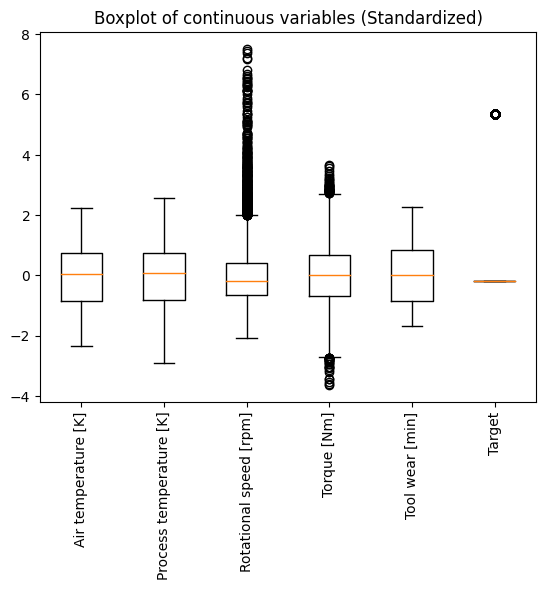

In [175]:
plt.boxplot(StandardScaler().fit_transform(df.select_dtypes(include=['float64','int64'])),labels=df.select_dtypes(include=['float64','int64']).columns)
plt.title('Boxplot of continuous variables (Standardized)')
plt.xticks(rotation=90);

In [176]:
df['Failure Type'].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

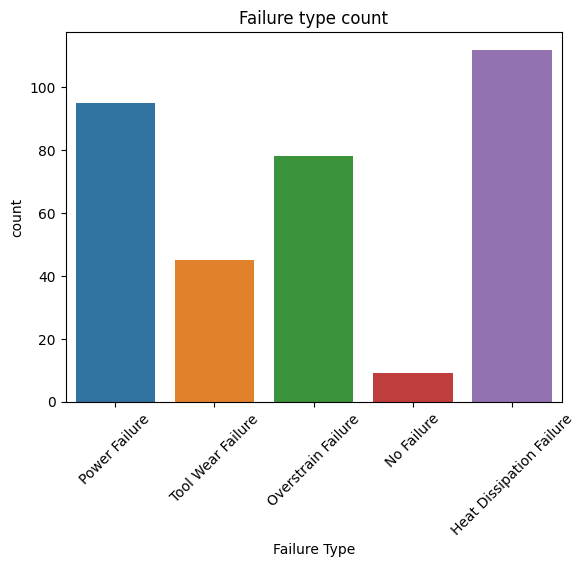

In [177]:
sns.countplot(x='Failure Type',data=df[df['Target']==1])
plt.title('Failure type count')
plt.xticks(rotation=45);

In [16]:
df['Failure Type'].value_counts(normalize=True)

No Failure                  0.9652
Heat Dissipation Failure    0.0112
Power Failure               0.0095
Overstrain Failure          0.0078
Tool Wear Failure           0.0045
Random Failures             0.0018
Name: Failure Type, dtype: float64

In [17]:
print('Amount of failures: {}'.format(df['Target'].sum()))

Amount of failures: 339


In [18]:
print('Failed to non failed ratio: {}%'.format(100*df['Target'].sum()/df.shape[0]))

Failed to non failed ratio: 3.39%


In [19]:
df['Type'].value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

<AxesSubplot:xlabel='UDI'>

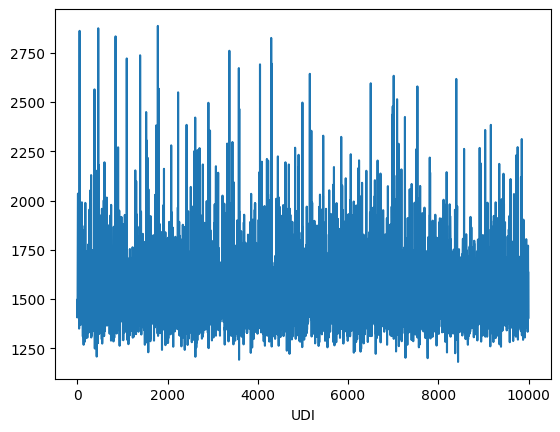

In [20]:
df[df['Type']=='L']['Rotational speed [rpm]'].plot()

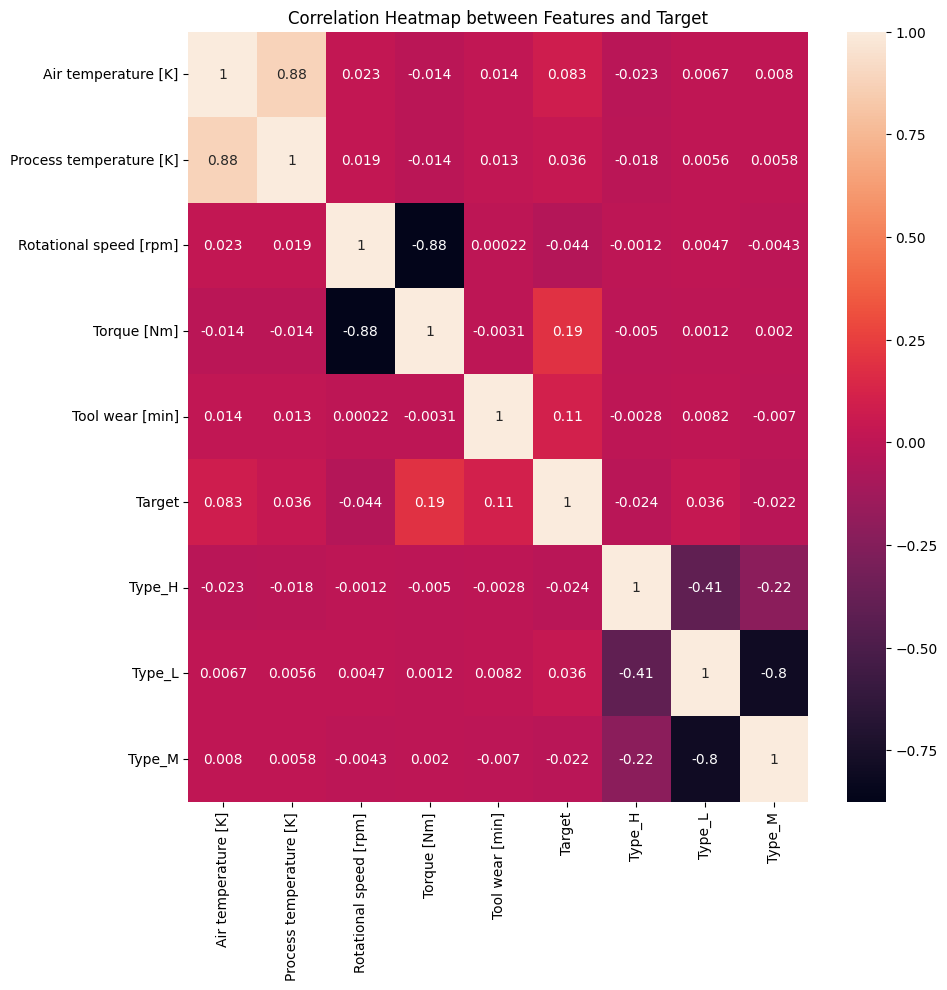

In [21]:
plt.figure(figsize=(10,10))
sns.heatmap(df.join(pd.get_dummies(df['Type'],prefix='Type')).corr(),annot=True)
plt.title('Correlation Heatmap between Features and Target');

The following can be observed:
- A negative correlation between Torque and Rotational Speed
- Torque and tool wear slightly increase the chance of a failure

# __Step 3:__ 
Features and Target Preparation

In [162]:
# Splitting of Dataframe into X and y1,y2
X=df.drop(['Target','Failure Type'],axis=1)
y1=df['Target']

In [163]:
# One-Hot encoding of feature 'Type' + StandardScaling of all features
X=X.join(pd.get_dummies(X['Type'],prefix='Type'))
X.drop(['Type','Product ID'],axis=1,inplace=True)

#Scaling
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

In [164]:
# One-Hot encoding of target 'Failure Type'
y2=pd.get_dummies(df['Failure Type'],prefix='F-Type')
display(y2)

,F-Type_Heat Dissipation Failure,F-Type_No Failure,F-Type_Overstrain Failure,F-Type_Power Failure,F-Type_Random Failures,F-Type_Tool Wear Failure
UDI,,,,,,
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0
5,0,1,0,0,0,0
...,...,...,...,...,...,...
9996,0,1,0,0,0,0
9997,0,1,0,0,0,0
9998,0,1,0,0,0,0


# __Step 4:__ 
Setting up and validating several classifiers

In [30]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y1,test_size=0.2,random_state=123)

# Oversampling the train dataset since failures are under-represented!
ro=RandomOverSampler()
X_train_ro,y_train_ro=ro.fit_resample(X_train,y_train)

K-Nearest Neighbors

In [31]:
# Algorithm Setup
knn=KNeighborsClassifier(n_neighbors=10, metric='manhattan', weights='uniform')

In [32]:
knn.fit(X_train_ro,y_train_ro)
y_pred=knn.predict(X_test)
display(pd.crosstab(y_test,y_pred,rownames=['Reality'],colnames=['Prediction']))
print(classification_report(y_test,y_pred))

Prediction,0,1
Reality,,
0,1823,101
1,30,46


              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1924
           1       0.31      0.61      0.41        76

    accuracy                           0.93      2000
   macro avg       0.65      0.78      0.69      2000
weighted avg       0.96      0.93      0.94      2000



Finding the best hyper-parameters for KNN with GridSearchCV

In [33]:
knn=KNeighborsClassifier()
n_neighbors=[2,3,4,5,7,9,11,13,15,17,19,21]
metric=['euclidean','manhattan','minkowski']
weights=['uniform','distance']
parameters=dict(n_neighbors=n_neighbors,metric=metric,weights=weights)

timestamp=datetime.now().strftime('%d.%m.%Y %H:%M:%S')
print(timestamp)
grid=GridSearchCV(estimator=knn,param_grid=parameters,n_jobs=-1,cv=5,scoring='f1',error_score=0,verbose=3)
grid.fit(X_train_ro,y_train_ro)
timestamp=datetime.now().strftime('%d.%m.%Y %H:%M:%S')
print(timestamp)
print(grid.best_params_)
print(grid.best_score_)

08.05.2023 10:31:53
Fitting 5 folds for each of 72 candidates, totalling 360 fits
08.05.2023 10:32:07
{'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'uniform'}
0.9926238215415


In [34]:
y_pred=grid.predict(X_test)
display(pd.crosstab(y_test,y_pred,rownames=['Reality'],colnames=['Prediction']))
print(classification_report(y_test,y_pred))

Prediction,0,1
Reality,,
0,1904,20
1,46,30


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1924
           1       0.60      0.39      0.48        76

    accuracy                           0.97      2000
   macro avg       0.79      0.69      0.73      2000
weighted avg       0.96      0.97      0.96      2000



Grid Search with Random Forest Classifier

In [48]:
rfc=RandomForestClassifier()
n_estimators=[10,100,500,1000]
max_features=['sqrt','log2',1,5,10,20]
parameters=dict(n_estimators=n_estimators,max_features=max_features)

timestamp=datetime.now().strftime('%d.%m.%Y %H:%M:%S')
print(timestamp)
grid=GridSearchCV(estimator=rfc,param_grid=parameters,n_jobs=-1,cv=5,scoring='f1',error_score=0,verbose=3)
grid.fit(X_train_ro,y_train_ro)
timestamp=datetime.now().strftime('%d.%m.%Y %H:%M:%S')
print(timestamp)
print(grid.best_params_)
print(grid.best_score_)

08.05.2023 10:41:42
Fitting 5 folds for each of 24 candidates, totalling 120 fits
08.05.2023 10:42:59
{'max_features': 1, 'n_estimators': 100}
0.997487130822521


In [54]:
y_pred=grid.predict(X_test)
display(pd.crosstab(y_test,y_pred,rownames=['Reality'],colnames=['Prediction']))
print(classification_report(y_test,y_pred))

Prediction,0,1
Reality,,
0,1916,8
1,39,37


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1924
           1       0.82      0.49      0.61        76

    accuracy                           0.98      2000
   macro avg       0.90      0.74      0.80      2000
weighted avg       0.97      0.98      0.97      2000



In [52]:
#dump(grid,'./Joblibs/RFC_Grid.joblib')
grid=load('./Joblibs/RFC_Grid.joblib')

# Results:
The Random Forest Classifier provides an overall better failure detection than the KNN-Classifier

# __Step 5: Keras Multi-Class Classification__ 
Setting up and validating Keras Classifier
trained on the 6 different failure types

In [165]:
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

# Encoding Failure type to categorical: to_categorical
# Generating Input Data and Validation Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y2,test_size=0.2,random_state=123)

ro=RandomOverSampler()
X_train_ro,y_train_ro=ro.fit_resample(np.array(X_train),np.array(y_train))

X_test=np.array(X_test)
y_test=np.array(y_test)

# There are six failure types
f_types=6

Model builder that takes learning rate, failure types and has a dropout switch

In [166]:
def build_model(f_types,lr,dropout_switch=False):
    model=Sequential()
    # Dense Layer
    model.add(Dense(units=256,input_shape=(8,)))
    # Activation Function
    model.add(LeakyReLU(alpha=0.05))
    # Dropout
    if dropout_switch==True:
        model.add(Dropout(0.2))
    model.add(Dense(units=64))
    model.add(LeakyReLU(alpha=0.05))
    if dropout_switch==True:
        model.add(Dropout(0.2))
    model.add(Dense(units=f_types,activation='softmax'))
    
    optimizer=Adam(learning_rate=lr,)
    
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=[Precision(),Recall(),'Accuracy'])
    #model.summary()
    return model

In [93]:
# Building a model with a 6 fold classification and learning rate of 0.0001 with dropout layers activated
model=build_model(6,1e-4,True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               2304      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                16448     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 6)                

In [77]:
# early_stopping=EarlyStopping(monitor='val_loss',
#                              patience=1,
#                              min_delta=0.001,verbose=1)
# reduce_learning_rate=ReduceLROnPlateau(monitor='val_loss',
#                                       factor=0.1,
#                                       patience=3,
#                                       min_delta=0.1,
#                                       cooldown=4,
#                                       verbose=1)

In [94]:
# First run with 200 epochs and batch size = 16
history=model.fit(X_train_ro, 
                  y_train_ro, 
                  validation_data=(X_test,y_test), 
                  epochs = 200, 
                  batch_size = 16) 

Epoch 1/200
2899/2899 [==============================] - 3s 1ms/step - loss: 0.8244 - precision_5: 0.8549 - recall_5: 0.5114 - accuracy: 0.0000e+00 - val_loss: 0.8254 - val_precision_5: 0.7077 - val_recall_5: 0.5870 - val_accuracy: 0.0000e+00
Epoch 2/200
2899/2899 [==============================] - 3s 932us/step - loss: 0.4607 - precision_5: 0.8692 - recall_5: 0.7813 - accuracy: 0.0000e+00 - val_loss: 0.7804 - val_precision_5: 0.7010 - val_recall_5: 0.6365 - val_accuracy: 0.0000e+00
Epoch 3/200
2899/2899 [==============================] - 3s 896us/step - loss: 0.3751 - precision_5: 0.8919 - recall_5: 0.8350 - accuracy: 1.0782e-05 - val_loss: 0.6527 - val_precision_5: 0.7397 - val_recall_5: 0.6935 - val_accuracy: 0.0000e+00
Epoch 4/200
2899/2899 [==============================] - 2s 860us/step - loss: 0.3195 - precision_5: 0.9076 - recall_5: 0.8697 - accuracy: 1.7970e-05 - val_loss: 0.6278 - val_precision_5: 0.7407 - val_recall_5: 0.7085 - val_accuracy: 0.0000e+00
Epoch 5/200
2899/2899 

2899/2899 [==============================] - 2s 817us/step - loss: 0.0421 - precision_5: 0.9893 - recall_5: 0.9890 - accuracy: 0.0838 - val_loss: 0.2804 - val_precision_5: 0.9434 - val_recall_5: 0.9425 - val_accuracy: 0.1462
Epoch 70/200
2899/2899 [==============================] - 2s 843us/step - loss: 0.0413 - precision_5: 0.9890 - recall_5: 0.9886 - accuracy: 0.0852 - val_loss: 0.2875 - val_precision_5: 0.9395 - val_recall_5: 0.9395 - val_accuracy: 0.1507
Epoch 71/200
2899/2899 [==============================] - 3s 986us/step - loss: 0.0409 - precision_5: 0.9892 - recall_5: 0.9889 - accuracy: 0.0863 - val_loss: 0.2655 - val_precision_5: 0.9455 - val_recall_5: 0.9455 - val_accuracy: 0.1575
Epoch 72/200
2899/2899 [==============================] - 3s 865us/step - loss: 0.0398 - precision_5: 0.9891 - recall_5: 0.9889 - accuracy: 0.0886 - val_loss: 0.2887 - val_precision_5: 0.9440 - val_recall_5: 0.9435 - val_accuracy: 0.1554
Epoch 73/200
2899/2899 [==============================] - 2s 

2899/2899 [==============================] - 2s 829us/step - loss: 0.0270 - precision_5: 0.9926 - recall_5: 0.9925 - accuracy: 0.1724 - val_loss: 0.3162 - val_precision_5: 0.9595 - val_recall_5: 0.9595 - val_accuracy: 0.3134
Epoch 138/200
2899/2899 [==============================] - 2s 849us/step - loss: 0.0270 - precision_5: 0.9929 - recall_5: 0.9928 - accuracy: 0.1726 - val_loss: 0.3249 - val_precision_5: 0.9545 - val_recall_5: 0.9540 - val_accuracy: 0.3103
Epoch 139/200
2899/2899 [==============================] - 3s 872us/step - loss: 0.0269 - precision_5: 0.9927 - recall_5: 0.9926 - accuracy: 0.1751 - val_loss: 0.3176 - val_precision_5: 0.9560 - val_recall_5: 0.9560 - val_accuracy: 0.3143
Epoch 140/200
2899/2899 [==============================] - 2s 843us/step - loss: 0.0269 - precision_5: 0.9927 - recall_5: 0.9926 - accuracy: 0.1761 - val_loss: 0.3180 - val_precision_5: 0.9565 - val_recall_5: 0.9565 - val_accuracy: 0.3174
Epoch 141/200
2899/2899 [==============================] -

Evaluation of the model

In [113]:
print("Val_loss min: %.2f" % np.array(history.history['val_loss']).min())
print("val_loss mean: %.2f" % np.array(history.history['val_loss']).mean())

Val_loss min: 0.26
val_loss mean: 0.33


In [95]:
# Prediction of failure types
y_pred=model.predict(X_test)
# Selecting failure type with highest probabilty
y_pred=y_pred.argmax(axis=1)
y_test_argmax=np.array(y_test).argmax(axis=1)
display(pd.crosstab(y_test_argmax,y_pred,rownames=['Reality'],colnames=['Prediction']))
print(classification_report(y_test_argmax,y_pred))

print("Legend:")
for i,j in zip(range(0,6),y2.columns):
    print(i, j)

Prediction,0,1,2,3,4,5
Reality,,,,,,
0,15,1,0,0,0,0
1,5,1870,9,4,5,30
2,0,1,23,0,0,0
3,0,2,1,17,0,0
4,0,5,0,0,0,0
5,0,10,0,0,0,2


              precision    recall  f1-score   support

           0       0.75      0.94      0.83        16
           1       0.99      0.97      0.98      1923
           2       0.70      0.96      0.81        24
           3       0.81      0.85      0.83        20
           4       0.00      0.00      0.00         5
           5       0.06      0.17      0.09        12

    accuracy                           0.96      2000
   macro avg       0.55      0.65      0.59      2000
weighted avg       0.97      0.96      0.97      2000

Legend:
0 F-Type_Heat Dissipation Failure
1 F-Type_No Failure
2 F-Type_Overstrain Failure
3 F-Type_Power Failure
4 F-Type_Random Failures
5 F-Type_Tool Wear Failure


In [96]:
#model.save('./Joblibs/model_keras_1')
#model=load_model('./Joblibs/model_keras_1')

INFO:tensorflow:Assets written to: ./Joblibs/model_keras_1\assets


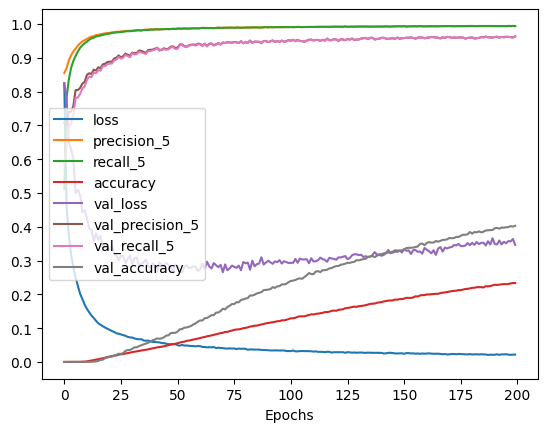

In [97]:
for i in history.history.keys():
    #print(i)
    plt.plot(history.history[i],label=i)
plt.legend()
plt.xlabel('Epochs')
plt.yticks(np.arange(0,1.1,0.1));

Setting up environment to find the best hyperparameters for fine tuning

Also adding callback functions for early stopping and learning rate reduction to prevent overfitting

In [116]:
batch_sizes=[2**x for x in range(4,9)]
dropout_switch=[True,False]
lrs=[1/(10**x) for x in range(3,5)]

history_dict=dict()
epochs=200

# Callback functions
early_stopping=EarlyStopping(monitor='val_loss',
                             patience=10,
                             min_delta=0.001,verbose=1)
reduce_learning_rate=ReduceLROnPlateau(monitor='val_loss',
                                      factor=0.1,
                                      patience=3,
                                      min_delta=0.1,
                                      cooldown=4,
                                      verbose=1)

total_length=len(batch_sizes)*len(dropout_switch)*len(lrs)

print('Running a total of {} iterations'.format(total_length))

counter=1

for i in batch_sizes:
    for j in dropout_switch:
        for k in lrs:
            string='BS: '+str(i)+' Dropout: '+str(j)+' LR: '+str(k)
            print('\n')
            print('---------------------------------')
            print(datetime.now().strftime('%d.%m.%Y %H:%M:%S'))
            print(string)
            print('{} of {}'.format(counter,total_length))
            model=build_model(6,k,j)
            history=model.fit(X_train_ro, y_train_ro, validation_data=(X_test,y_test), epochs = epochs, batch_size = i,verbose=0, callbacks=[reduce_learning_rate,early_stopping])
            
            print("Val_loss min: %.2f" % np.array(history.history['val_loss']).min())
            print("val_loss mean: %.2f" % np.array(history.history['val_loss']).mean())
            print('---------------------------------')
            history_dict[string]=history.history
            counter += 1

Running a total of 20 iterations


---------------------------------
08.05.2023 12:06:29
BS: 16 Dropout: True LR: 0.001
1 of 20

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00021: early stopping
Val_loss min: 0.28
val_loss mean: 0.31
---------------------------------


---------------------------------
08.05.2023 12:07:12
BS: 16 Dropout: True LR: 0.0001
2 of 20

Epoch 00009: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00024: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00025: early stopping
Val_loss min: 0.44
val_loss mean: 0.51
---------------------------------


---------------------------------
08.05.2023 12:08:00
BS: 16 Dropout: False LR: 0.0


Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 00019: early stopping
Val_loss min: 0.27
val_loss mean: 0.33
---------------------------------


---------------------------------
08.05.2023 12:12:44
BS: 256 Dropout: False LR: 0.0001
20 of 20

Epoch 00011: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00019: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 00027: early stopping
Val_loss min: 0.56
val_loss mean: 0.69
---------------------------------


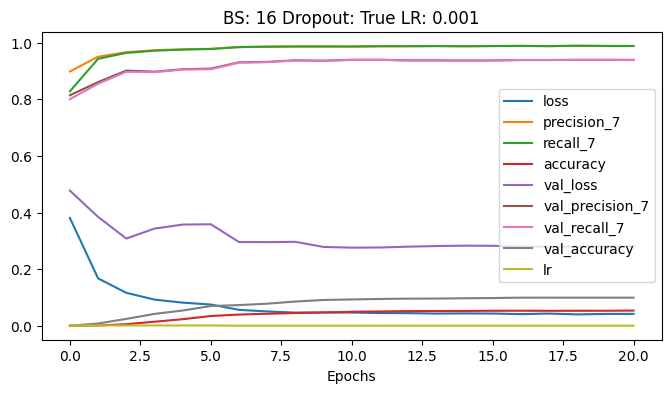

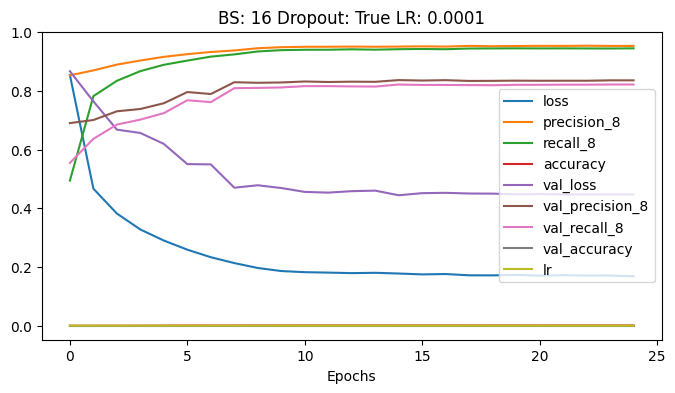

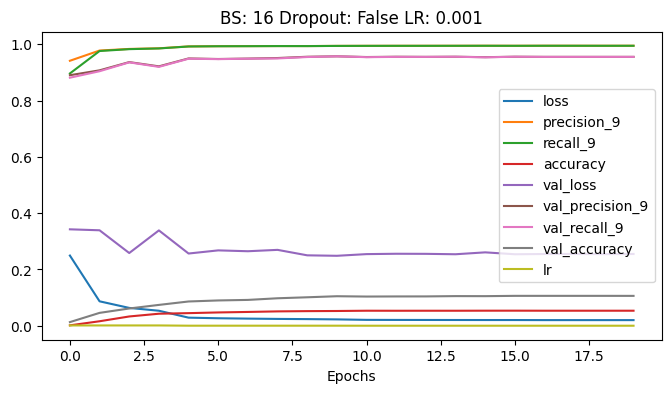

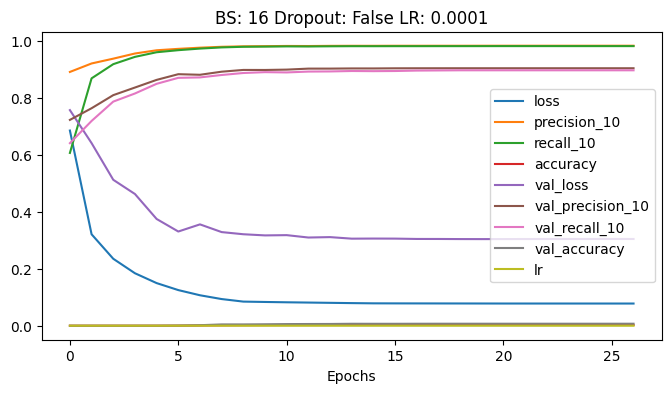

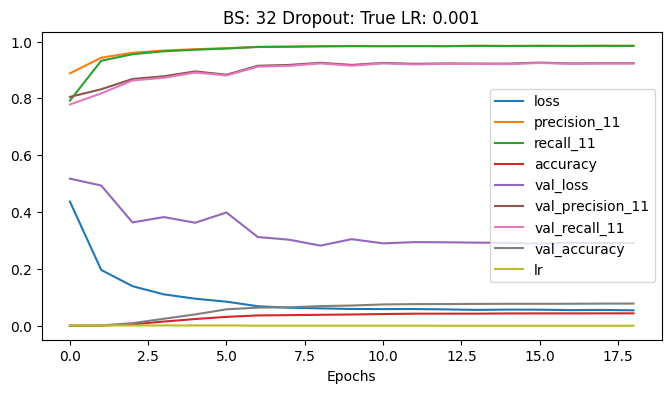

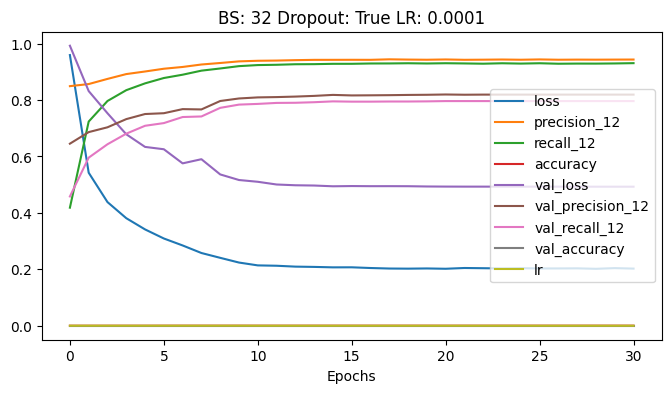

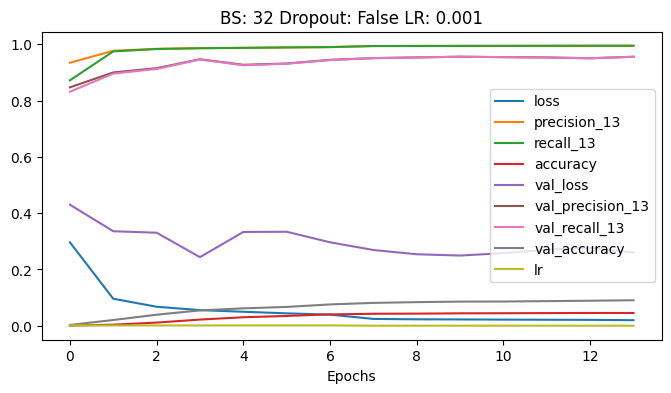

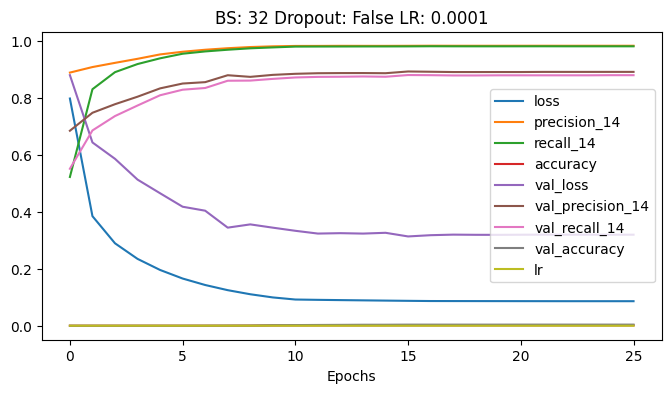

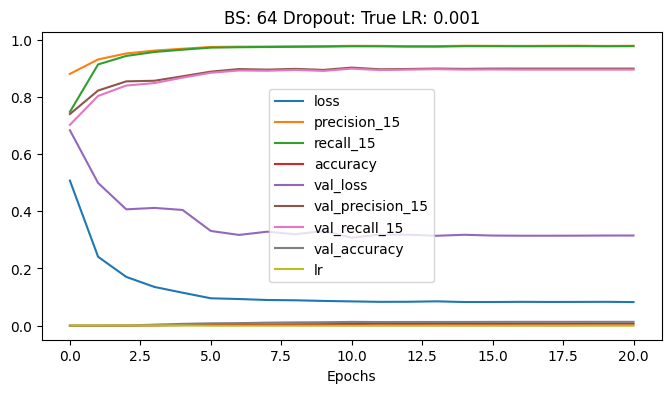

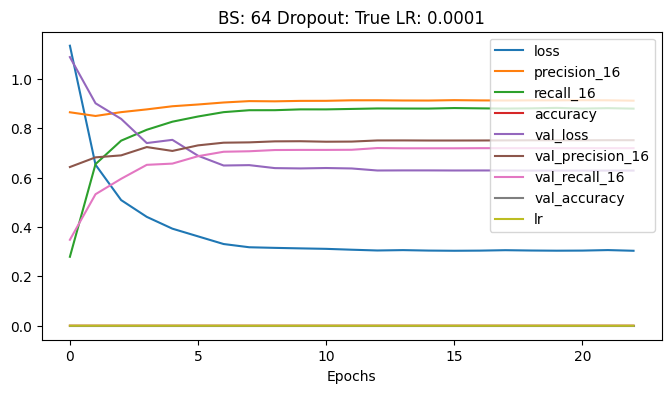

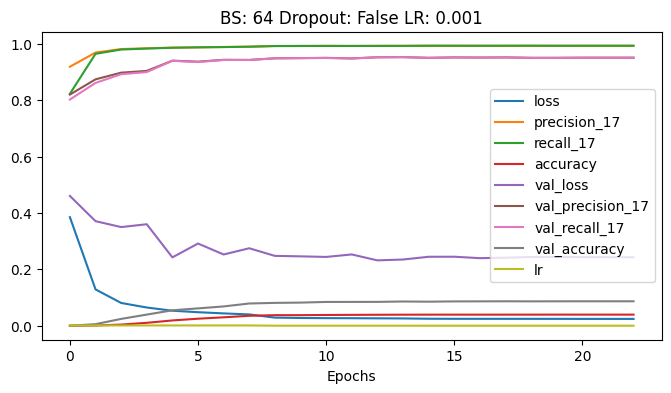

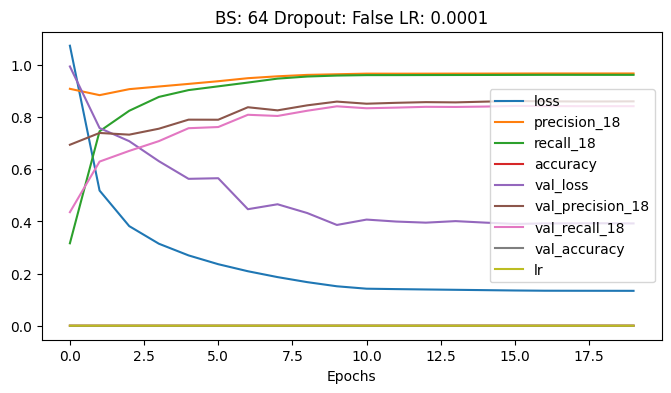

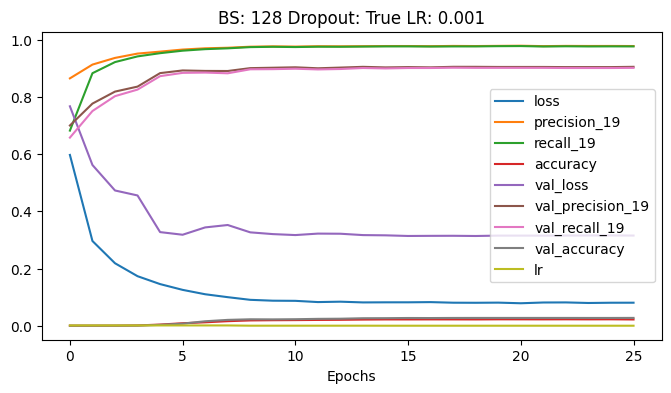

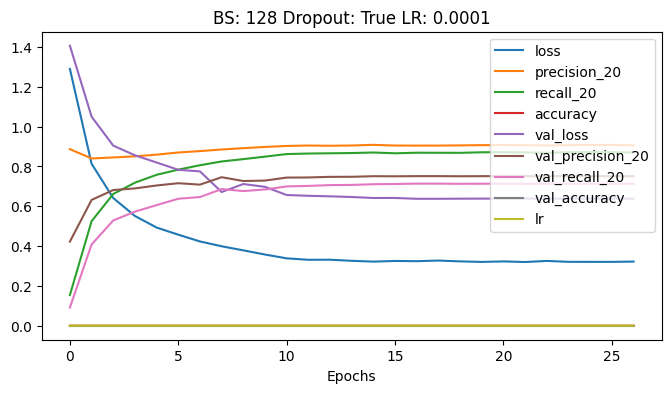

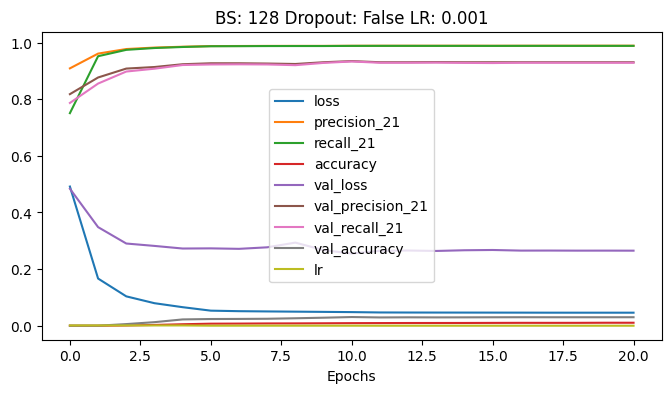

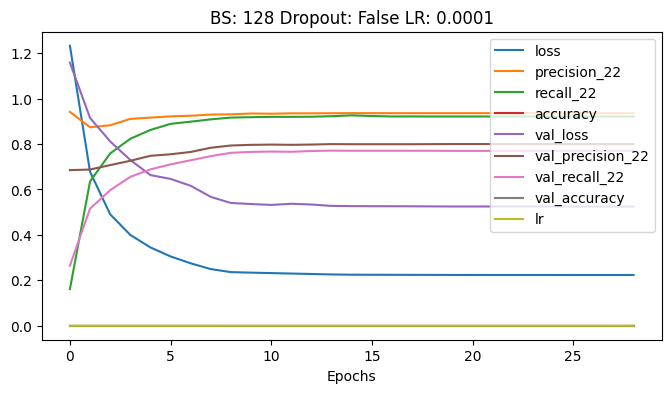

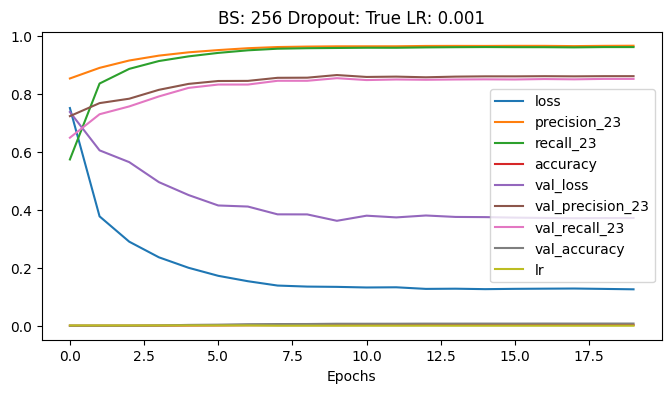

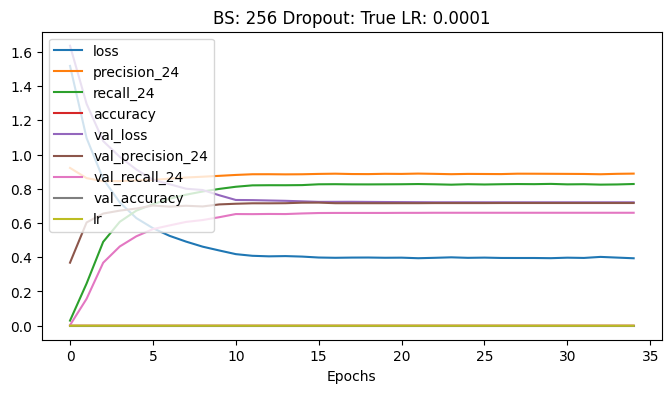

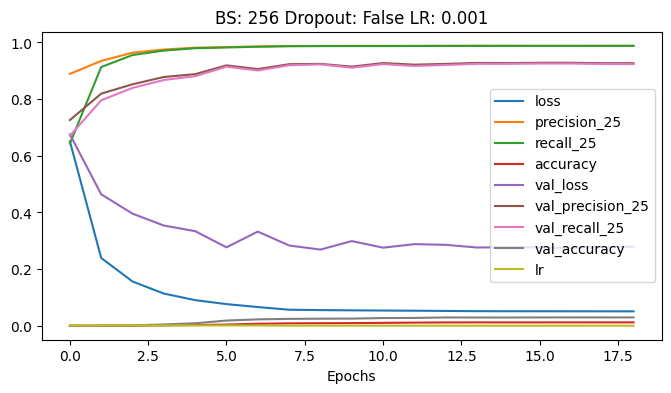

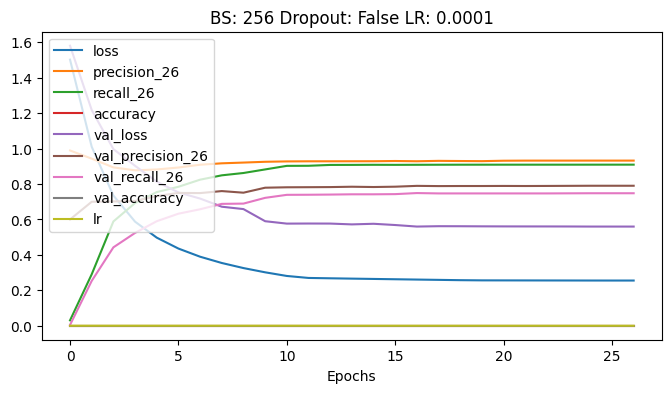

In [135]:
for key in history_dict.keys():
    #print(history_dict[key])
    plt.figure(figsize=(8,4))
    for i in history_dict[key]:
        #print(history_dict[key][i])
        plt.plot(history_dict[key][i],label=i)    
        plt.xlabel('Epochs')
        plt.title(key)
        plt.legend()

Selecting suitable parameters (learning rate, batch size)

In [167]:
model=build_model(6,1e-3,True)
history=model.fit(X_train_ro,
                  y_train_ro,
                  validation_data=(X_test,y_test),
                  epochs = 200,
                  batch_size = 64,
                  verbose=1,
                  callbacks=[reduce_learning_rate,early_stopping])

Epoch 1/200
725/725 [==============================] - 1s 2ms/step - loss: 0.5039 - precision_35: 0.8794 - recall_35: 0.7499 - accuracy: 4.3128e-05 - val_loss: 0.6425 - val_precision_35: 0.7554 - val_recall_35: 0.7165 - val_accuracy: 0.0000e+00
Epoch 2/200
725/725 [==============================] - 1s 1ms/step - loss: 0.2351 - precision_35: 0.9321 - recall_35: 0.9143 - accuracy: 1.1860e-04 - val_loss: 0.4191 - val_precision_35: 0.8438 - val_recall_35: 0.8290 - val_accuracy: 8.3333e-05
Epoch 3/200
725/725 [==============================] - 1s 1ms/step - loss: 0.1630 - precision_35: 0.9537 - recall_35: 0.9463 - accuracy: 5.3550e-04 - val_loss: 0.3874 - val_precision_35: 0.8644 - val_recall_35: 0.8540 - val_accuracy: 0.0023
Epoch 4/200
725/725 [==============================] - 1s 1ms/step - loss: 0.1283 - precision_35: 0.9641 - recall_35: 0.9600 - accuracy: 0.0021 - val_loss: 0.3466 - val_precision_35: 0.8774 - val_recall_35: 0.8695 - val_accuracy: 0.0088
Epoch 5/200
719/725 [===========

In [169]:
model.save('./Joblibs/model_keras_2')
#model=load_model('./Joblibs/model_keras_2')

INFO:tensorflow:Assets written to: ./Joblibs/model_keras_2\assets


Evaluation

Prediction,0,1,2,3,4,5
Reality,,,,,,
0,16,0,0,0,0,0
1,25,1740,19,10,27,102
2,0,1,23,0,0,0
3,0,0,0,20,0,0
4,0,5,0,0,0,0
5,0,6,1,0,0,5


              precision    recall  f1-score   support

           0       0.39      1.00      0.56        16
           1       0.99      0.90      0.95      1923
           2       0.53      0.96      0.69        24
           3       0.67      1.00      0.80        20
           4       0.00      0.00      0.00         5
           5       0.05      0.42      0.08        12

    accuracy                           0.90      2000
   macro avg       0.44      0.71      0.51      2000
weighted avg       0.97      0.90      0.93      2000

Legend:
0 F-Type_Heat Dissipation Failure
1 F-Type_No Failure
2 F-Type_Overstrain Failure
3 F-Type_Power Failure
4 F-Type_Random Failures
5 F-Type_Tool Wear Failure


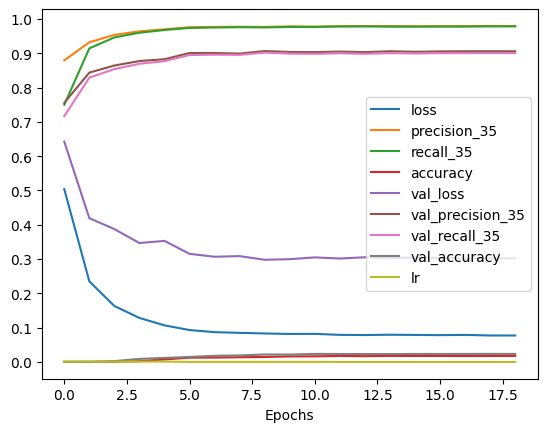

In [168]:
for i in history.history.keys():
    plt.plot(history.history[i],label=i)
plt.legend()
plt.xlabel('Epochs')
plt.yticks(np.arange(0,1.1,0.1));

y_pred=model.predict(X_test)
y_pred=y_pred.argmax(axis=1)
y_test_argmax=np.array(y_test).argmax(axis=1)
display(pd.crosstab(y_test_argmax,y_pred,rownames=['Reality'],colnames=['Prediction']))
print(classification_report(y_test_argmax,y_pred))

print("Legend:")
for i,j in zip(range(0,6),y2.columns):
    print(i, j)

# Step 6
Conclusion

- The dataset is heavily shifted towards non failures, oversampling was neccessary!
- Binary failure prediction can be done with a an precision of 0.82 and a recall of 0.49 utilizing a Random Forest Classifier
- A Dense Neural Network was set up that can predict the failure category with an accuracy of 0.90
- The exception are random failures, since the seem to follow a random pattern that cannot be used for training